In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure(dpi=150)
    if title:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)
    plt.show()

In [3]:
epochs = 100

# UTKFace Data

In [4]:
batch_size = 16

In [5]:
from data import UTKFace
dataset = UTKFace(label='gender', transform=transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()])
                 )

In [6]:
idcs = np.arange(len(dataset))
np.random.seed(0) # This is important to split the same way every single time
np.random.shuffle(idcs)
split_idx = int(0.9 * len(dataset))
train_idcs = idcs[:split_idx]
test_idcs = idcs[split_idx:]

In [7]:
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)

### Toggle cell below for sample debugging

In [8]:
train_dataset = torch.utils.data.Subset(train_dataset, range(64))
test_dataset = torch.utils.data.Subset(test_dataset, range(64))

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

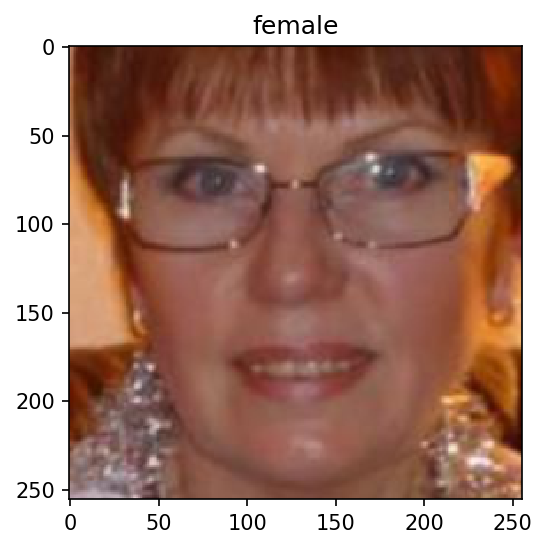

In [10]:
a_face, gender_idx = dataset[10000]
show(a_face, dataset.classes[gender_idx])

# VAE Model

In [11]:
from models import StyleVAE

In [12]:
device = torch.device("cuda")

In [13]:
model = StyleVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in tqdm(enumerate(test_loader)):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 256, 256)[:n]])
                show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(epoch))
            break

    test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

# Load

In [15]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/StyleVAE_UTKFace.pt'

In [16]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))  
    print("Loaded model")

Loaded model


# Train

100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


====> Epoch: 1 Average loss: 113525.9922


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 2 Average loss: 112586.5156


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 3 Average loss: 112728.3223


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 4 Average loss: 111928.2285


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 5 Average loss: 111474.8066


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 6 Average loss: 111170.7070


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 7 Average loss: 112241.6133


100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


====> Epoch: 8 Average loss: 110995.5391


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 9 Average loss: 110637.5469


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 10 Average loss: 111262.6504


0it [00:00, ?it/s]

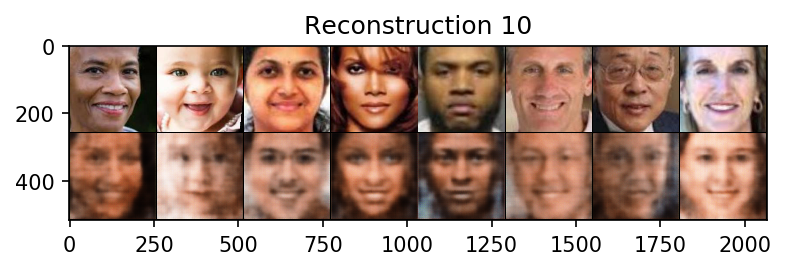


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 11 Average loss: 110434.0625


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 12 Average loss: 110439.3770


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 13 Average loss: 110349.0059


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 14 Average loss: 110523.4141


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 15 Average loss: 110085.1133


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


====> Epoch: 16 Average loss: 110672.7852


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 17 Average loss: 110755.7363


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 18 Average loss: 111041.7148


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 19 Average loss: 110613.2930


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]

====> Epoch: 20 Average loss: 110651.4746



0it [00:00, ?it/s]

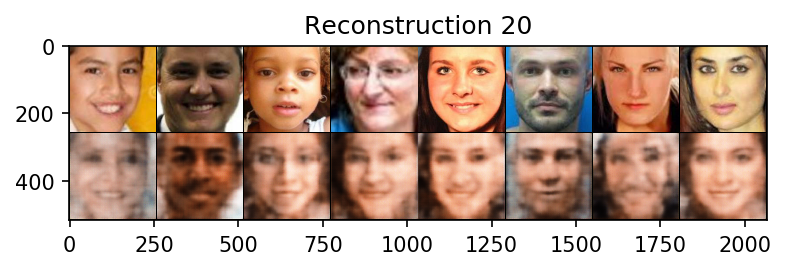


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 21 Average loss: 110553.6152


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 22 Average loss: 110094.9141


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 23 Average loss: 109853.7090


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 24 Average loss: 110299.1816


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 25 Average loss: 110323.2637


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 26 Average loss: 110539.1562


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


====> Epoch: 27 Average loss: 110020.4551


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 28 Average loss: 109986.9102


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 29 Average loss: 110377.2461


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 30 Average loss: 111664.8594


0it [00:00, ?it/s]

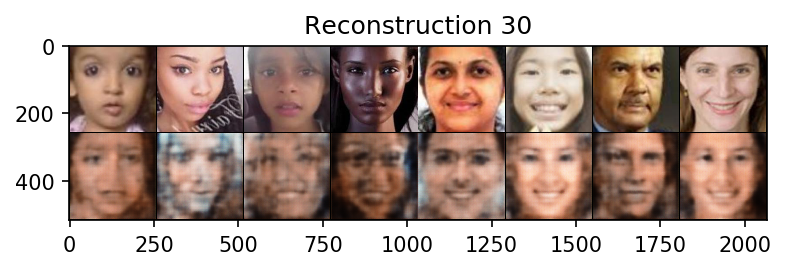


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 31 Average loss: 110248.4434


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 32 Average loss: 110345.3574


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 33 Average loss: 110257.2578


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 34 Average loss: 110371.3340


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 35 Average loss: 110239.9902


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 36 Average loss: 109823.5586


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 37 Average loss: 109788.5059


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


====> Epoch: 38 Average loss: 109873.2246


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 39 Average loss: 110024.4883


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 40 Average loss: 109671.4004


0it [00:00, ?it/s]

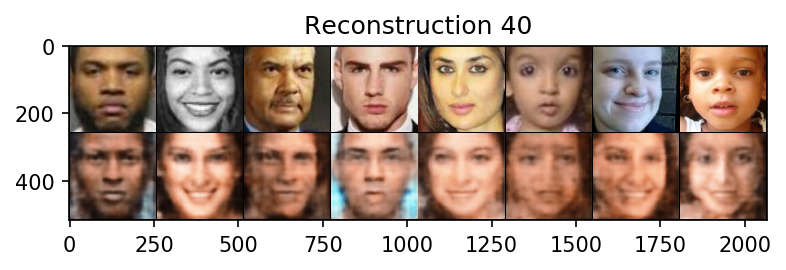


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 41 Average loss: 110052.1992


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 42 Average loss: 109609.8105


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 43 Average loss: 110155.6914


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 44 Average loss: 109512.7012


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 45 Average loss: 110003.5020


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 46 Average loss: 109778.8223


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 47 Average loss: 109846.7031


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 48 Average loss: 110125.6680


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 49 Average loss: 110219.0918


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 50 Average loss: 110327.8770


0it [00:00, ?it/s]

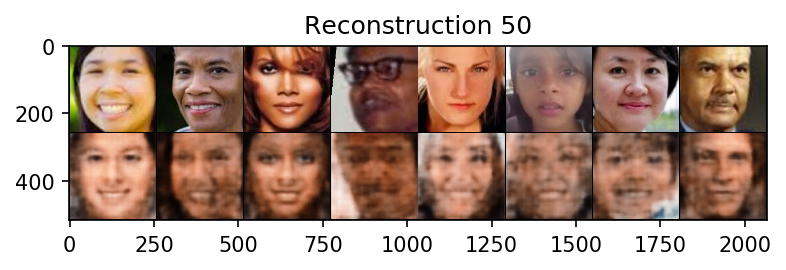


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 51 Average loss: 109944.7188


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 52 Average loss: 109824.9258


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 53 Average loss: 109897.0840


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 54 Average loss: 109679.1445


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 55 Average loss: 110753.2559


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 56 Average loss: 110302.2793


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 57 Average loss: 110113.6016


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 58 Average loss: 110005.8398


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 59 Average loss: 109704.7637


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 60 Average loss: 109701.4746


0it [00:00, ?it/s]

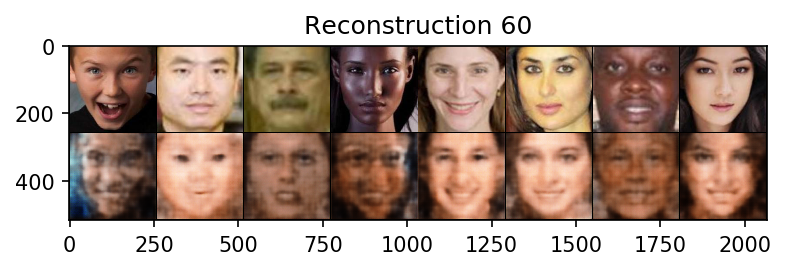


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 61 Average loss: 109694.2480


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


====> Epoch: 62 Average loss: 109629.2148


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 63 Average loss: 109666.2969


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 64 Average loss: 109538.2520


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 65 Average loss: 109610.8008


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 66 Average loss: 109604.8613


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 67 Average loss: 109535.3457


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 68 Average loss: 109628.8379


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 69 Average loss: 109494.7988


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

====> Epoch: 70 Average loss: 109394.8320



0it [00:00, ?it/s]

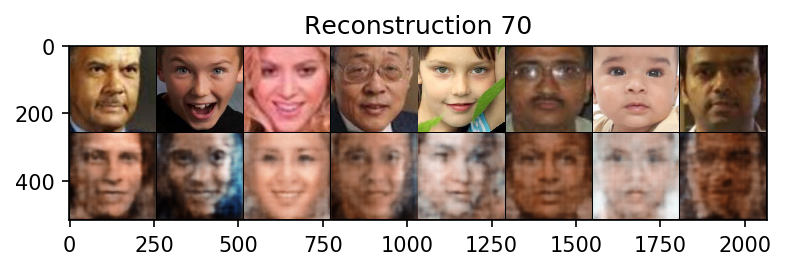


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 71 Average loss: 109515.9199


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 72 Average loss: 109409.5742


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 73 Average loss: 109718.6953


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 74 Average loss: 109553.5801


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 75 Average loss: 110190.4004


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 76 Average loss: 109610.4531


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 77 Average loss: 109819.8848


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 78 Average loss: 109773.5488


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 79 Average loss: 109553.6680


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]

====> Epoch: 80 Average loss: 109688.4492



0it [00:00, ?it/s]

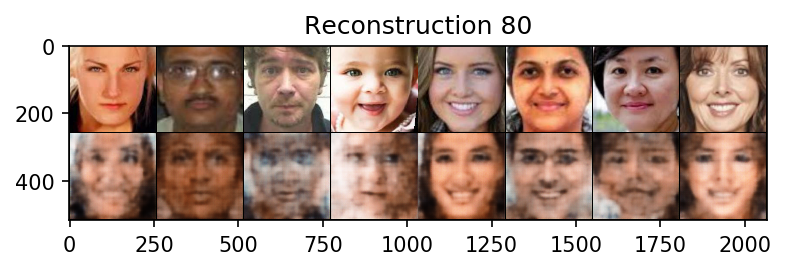


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 81 Average loss: 109339.1484


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 82 Average loss: 109611.0430


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 83 Average loss: 109642.0195


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 84 Average loss: 109300.7207


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 85 Average loss: 109688.2695


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


====> Epoch: 86 Average loss: 109397.4453


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


====> Epoch: 87 Average loss: 109622.6953


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 88 Average loss: 109439.5156


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 89 Average loss: 109520.0586


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]

====> Epoch: 90 Average loss: 109306.0410



0it [00:00, ?it/s]

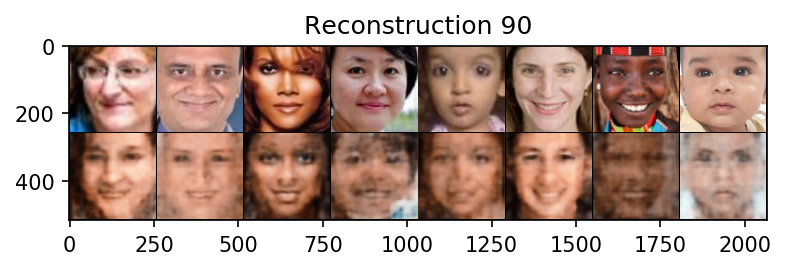


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 91 Average loss: 110060.9375


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


====> Epoch: 92 Average loss: 109587.3516


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 93 Average loss: 109631.6621


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 94 Average loss: 109727.4941


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 95 Average loss: 109465.1445


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 96 Average loss: 109404.6211


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 97 Average loss: 109436.6699


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 98 Average loss: 109950.2324


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


====> Epoch: 99 Average loss: 109378.8848


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

====> Epoch: 100 Average loss: 109454.6074



0it [00:00, ?it/s]

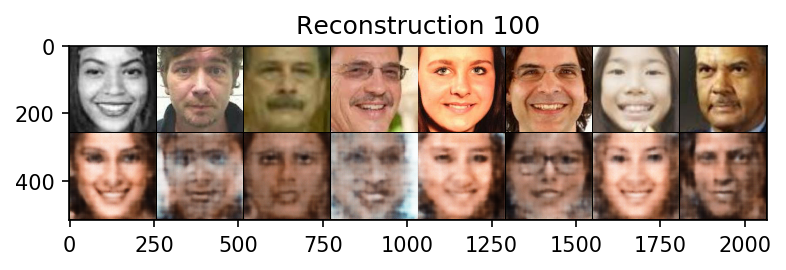

CPU times: user 9min 31s, sys: 5min 25s, total: 14min 57s
Wall time: 15min 3s


In [17]:
%%time
for epoch in range(1, epochs + 1):
    torch.cuda.empty_cache()
    train(epoch)
    
    torch.save(model.state_dict(), weight_path)
    
    if epoch % 10 == 0:
        test(epoch)
#     with torch.no_grad():
#         sample = torch.randn(8, 50).to(device)
#         sample = model.decode(sample).cpu()
#         show(make_grid(sample.view(8, 3, 256, 256)), 'Sample {}'.format(epoch))

# Evaluate

0it [00:00, ?it/s]

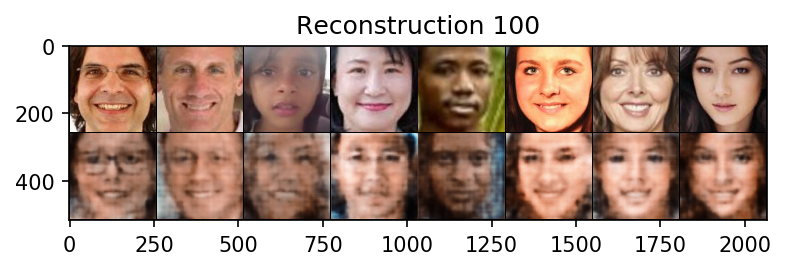

RuntimeError: shape '[64, 1, 256, 256]' is invalid for input of size 12582912

In [18]:
test(epoch)
with torch.no_grad():
    sample = torch.randn(64, 50).to(device)
    sample = model.decode(sample).cpu()
    show(make_grid(sample.view(64, 1, 256, 256)), 'Sample {}'.format(epoch))

# Save

In [ ]:
torch.save(model.state_dict(), weight_path)

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# Transition between average male and average female

In [ ]:
avg_male_enc = torch.zeros(model.latent_space, dtype=torch.float).to(device)
avg_female_enc = torch.zeros(model.latent_space, dtype=torch.float).to(device)
num_male, num_female = 0, 0

In [ ]:
dataset.classes

In [ ]:
for faces, genders in tqdm(test_loader):
    faces = faces.to(device)
    encodes, _ = model.encode(faces)
    male_encodes = encodes[genders == 1]
    female_encodes = encodes[genders == 0]
    avg_male_enc += male_encodes.sum(dim=0)
    avg_female_enc += female_encodes.sum(dim=0)
    num_male += (genders == 1).sum()
    num_female += (genders == 0).sum()

avg_male_enc /= num_male
avg_female_enc /= num_female

In [ ]:
import torchvision.utils
num_steps = 10 # num_steps = 1 -> two images
encodings = torch.empty((num_steps + 1, model.latent_space))
encodings.shape

In [ ]:
curr = avg_male_enc
step_vec = (avg_female_enc - avg_male_enc) / num_steps
for i in tqdm(range(num_steps + 1)):
    encodings[i] = curr
    curr += step_vec

In [ ]:
decoded_faces = model.decode(encodings.to(device)).detach().cpu()

In [ ]:
progressed_faces = torchvision.utils.make_grid(decoded_faces, nrow=num_steps + 1)
show(progressed_faces)

# Try it on Our Face

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
f_to_m_vec = avg_male_enc - avg_female_enc
jenny = np.expand_dims(io.imread('data/Headshots/Eddie.jpeg', as_grey=True), -1)
plt.imshow(jenny[:,:,0], cmap='gray')

In [ ]:
jenny_tensor = torch.from_numpy(np.expand_dims(jenny.transpose(2,0,1), 0)).float()
encodings = torch.empty((num_steps + 1, model.latent_space))
jenny_enc, _ = model.encode(jenny_tensor.to(device))

In [ ]:
jenny_reconst, _, _ = model(jenny_tensor.to(device))
show(torchvision.utils.make_grid(jenny_reconst.detach().cpu()))

In [ ]:
num_steps = 10
curr = jenny_enc
with torch.autograd.no_grad():
    step_vec = (f_to_m_vec) / num_steps
    for i in tqdm(range(num_steps + 1)):
        encodings[i] = curr
        curr += step_vec

In [ ]:
jenny_progressed = model.decode(encodings.to(device))
jenny_progressed = torchvision.utils.make_grid(jenny_progressed, nrow=num_steps + 1).detach().cpu()
show(jenny_progressed)